In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import os

In [10]:
def calculate_projective_transformation(control_points, destination_points):
    """Berechnet die Homographie für beliebig viele Passpunkte."""
    if len(control_points) != len(destination_points):
        raise ValueError('Anzahl der Passpunkte muss gleich sein')

    n = len(control_points)
    A = np.zeros((2*n, 9))

    for i in range(n):
        x, y = control_points[i]
        u, v = destination_points[i]
        A[2*i] = [x, y, 1, 0, 0, 0, -u*x, -u*y, -u]
        A[2*i+1] = [0, 0, 0, x, y, 1, -v*x, -v*y, -v]

    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    H /= H[2, 2]
    return H

def projective_transform(image, H, output_shape):
    """Transformiert ein Bild mit einer Homographie."""
    H_inv = np.linalg.inv(H)
    h_out, w_out = output_shape
    transformed = np.zeros((h_out, w_out, 3), dtype=np.uint8)

    for y_out in range(h_out):
        for x_out in range(w_out):
            dst_point = np.array([x_out, y_out, 1])
            src_point = H_inv @ dst_point
            src_point /= src_point[2]

            x_src = int(round(src_point[0]))
            y_src = int(round(src_point[1]))

            if 0 <= x_src < image.shape[1] and 0 <= y_src < image.shape[0]:
                transformed[y_out, x_out] = image[y_src, x_src]

    return transformed

def compute_weight_map(image):
    """Berechnet die Gewichtung für jedes Pixel im Bild."""
    h, w = image[0], image[1]
    weight_map = np.zeros((h, w))

    for y in range(h):
        for x in range(w):
            dx = 1 - (2.0 / w) * abs(x - w/2)
            dy = 1 - (2.0 / h) * abs(y - h/2)
            weight_map[y, x] = dx * dy

    return weight_map

def blend_images(img1, img2, weight1, weight2, method='max'):
    """Verschmilzt zwei Bilder mit gewichteter Überlagerung.
        max : Pixel mit grö´ßerem Gewicht
        avg : gemittelt
    """
    panorama = np.zeros_like(img1)
    mask1 = (weight1 > 0)
    mask2 = (weight2 > 0)
    overlap = mask1 & mask2

    # Nicht-überlappende Bereiche
    panorama = np.where(mask1[:, :, None], img1, panorama)
    panorama = np.where(~mask1[:, :, None] & mask2[:, :, None], img2, panorama)

    # Überlappende Bereiche
    if method == 'max':
        max_mask = (weight1 > weight2)[:, :, None]
        panorama = np.where(overlap[:, :, None] & max_mask, img1, panorama)
        panorama = np.where(overlap[:, :, None] & ~max_mask, img2, panorama)

    elif method == 'avg':
        total_weight = weight1 + weight2
        total_weight[total_weight == 0] = 1e-10  # Division mit Null

        for c in range(3):
            weighted_sum = img1[:, :, c].astype(float) * weight1 + img2[:, :, c].astype(float) * weight2
            panorama[:, :, c] = np.where(overlap, weighted_sum / total_weight, panorama[:, :, c])

    return panorama.astype(np.uint8)

def create_panorama(images, control_points_list, destination_points_list, output_shape, blend_method='max', blending_type='simple'):
    """Erstellt ein Panorama aus mehreren Bildern."""
    warped_images = []
    weight_maps = []

    # Transformiere jedes Bild und berechne Gewichtung
    for img, cps, dps in zip(images, control_points_list, destination_points_list):
        H = calculate_projective_transformation(cps, dps)
        warped = projective_transform(img, H, output_shape)
        warped_images.append(warped)
        weight_maps.append(compute_weight_map(warped.shape))

    # Beginne mit erstem Bild
    panorama = warped_images[0]
    total_weight = weight_maps[0]

    # Füge sequentiell weitere Bilder hinzu
    for i in range(1, len(warped_images)):
        if blending_type == 'simple':
            panorama = blend_images(panorama, warped_images[i], total_weight, weight_maps[i], method=blend_method)
        elif blending_type == 'multiband':
            panorama = multi_band_blend(panorama, warped_images[i], total_weight, weight_maps[i])

        # Aktualisiere Gesamtgewicht
        if blend_method == 'max':
            total_weight = np.maximum(total_weight, weight_maps[i])
        else:
            total_weight = total_weight + weight_maps[i]

    return panorama

def select_points(image_path, num_points, scale=1/3):
    image = cv2.imread(image_path)
    original_image = image.copy()

    height, width = image.shape[:2]
    new_size = (int(width * scale), int(height * scale))
    display_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    points_scaled = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            x_orig = int(x / scale)
            y_orig = int(y / scale)
            points_scaled.append([x_orig, y_orig])
            print(f"p{len(points_scaled)-1}: x={x_orig}, y={y_orig}")

            # Zeichne Punkt im skalierten Bild
            cv2.circle(display_image, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("Point Selection", display_image)

            if len(points_scaled) >= num_points:
                cv2.destroyAllWindows()

    cv2.imshow("Point Selection", display_image)
    cv2.setMouseCallback("Point Selection", click_event)
    cv2.waitKey(0)

    image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    points_np = np.array(points_scaled)

    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.scatter(points_np[:, 0], points_np[:, 1], c='red', s=40, marker='x')
    for i, (x, y) in enumerate(points_np):
        plt.text(x + 10, y - 10, f"p{i}", color='yellow', fontsize=12, weight='bold')
    plt.title("Ausgewählte Passpunkte")
    plt.show()

    return points_np

def get_world_coordinates(points):
    """Eingabe von Weltkoordinaten für Passpunkte."""
    world_points = []
    print(f"Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):")

    for i, point in enumerate(points):
        while True:
            try:
                coords = input(f"Punkt {i+1} (Bildposition: {point}): ")
                x, y = map(float, coords.split())
                world_points.append([x, y])
                break
            except:
                print("Ungültige Eingabe. Bitte zwei Zahlen mit Leerzeichen trennen.")

    return world_points

def multi_band_blend(img1, img2, weight1, weight2, sigma=5):
    # Konvertiere zu float32 für Berechnungen
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Tiefpass (Gauß-Filter)
    low_pass1 = cv2.GaussianBlur(img1, (0, 0), sigma)
    low_pass2 = cv2.GaussianBlur(img2, (0, 0), sigma)

    # Hochpass = Original - Tiefpass
    high_pass1 = img1 - low_pass1
    high_pass2 = img2 - low_pass2

    # Kombiniere Tiefpass (gewichteter Durchschnitt)
    total_weight = weight1 + weight2 + 1e-10  # Vermeide Division durch 0
    blended_low = (low_pass1 * weight1[..., None] + low_pass2 * weight2[..., None]) / total_weight[..., None]

    # Kombiniere Hochpass (Pixel mit höherem Gewicht)
    mask = (weight1 > weight2)[..., None]
    blended_high = np.where(mask, high_pass1, high_pass2)

    # Zusammensetzen
    blended = blended_low + blended_high
    return np.clip(blended, 0, 255).astype(np.uint8)



def perform_task(n = 2):
    num_images = n
    images = []
    control_points_list = []
    destination_points_list = []

    # Lade Bilder und wähle Passpunkte
    for i in range(1, num_images + 1):
        filename = f"b{i}.jpg"
        if not os.path.exists(filename):
            print(f"Fehler: Datei {filename} nicht gefunden!")
            return

        # Bild laden und in RGB konvertieren
        img_bgr = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)

        print(f"\n--- Bild {i} ---")
        print(f"Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.")

        # Passpunkte auswählen
        points = select_points(filename, 4)
        if len(points) < 4:
            print("Fehler: Mindestens 4 Punkte benötigt!")
            return

        control_points_list.append(points.tolist())

        # Weltkoordinaten eingeben
        world_points = get_world_coordinates(points)
        destination_points_list.append(world_points)

    # Ausgabegröße berechnen (basierend auf Weltkoordinaten)
    all_world_points = np.vstack(destination_points_list)
    min_x, min_y = np.min(all_world_points, axis=0)
    max_x, max_y = np.max(all_world_points, axis=0)

    # Normalisierte Weltkoordinaten erstellen
    normalized_destination_list = []
    for dps in destination_points_list:
        normalized = [[x - min_x, y - min_y] for x, y in dps]
        normalized_destination_list.append(normalized)

    output_shape = (int(max_y - min_y) + 100, int(max_x - min_x) + 100)

    # Panoramen erstellen
    print("\nErstelle Panorama mit einfacher Verschmelzung...")
    panorama_simple_max = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blend_method='max',
        blending_type='simple'
    )
    panorama_simple_avg = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blend_method='avg',
        blending_type='simple'
    )

    cv2.imwrite('panorama_simple_max.jpg', cv2.cvtColor(panorama_simple_max, cv2.COLOR_RGB2BGR))
    cv2.imwrite('panorama_simple_avg.jpg', cv2.cvtColor(panorama_simple_avg, cv2.COLOR_RGB2BGR))

    plt.figure(figsize=(20, 10))
    plt.subplot(121), plt.imshow(panorama_simple_max), plt.title('Einfache Verschmelzung (Max-Gewicht)')
    plt.subplot(122), plt.imshow(panorama_simple_avg), plt.title('Einfache Verschmelzung (AVG)')
    plt.tight_layout()
    plt.show()


--- Bild 1 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=786, y=2943
p1: x=909, y=1665
p2: x=2364, y=1740
p3: x=2535, y=2970


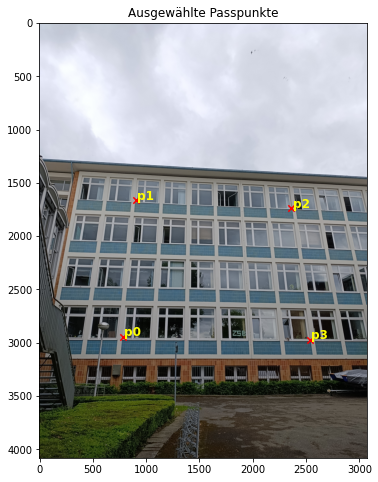

Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):

--- Bild 2 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=870, y=2727
p1: x=918, y=1446
p2: x=2148, y=1491
p3: x=2277, y=2721


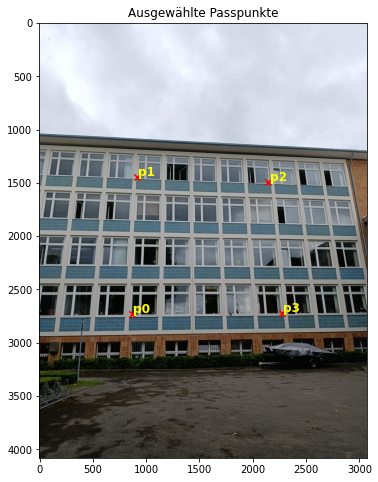

Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):

Erstelle Panorama mit einfacher Verschmelzung...


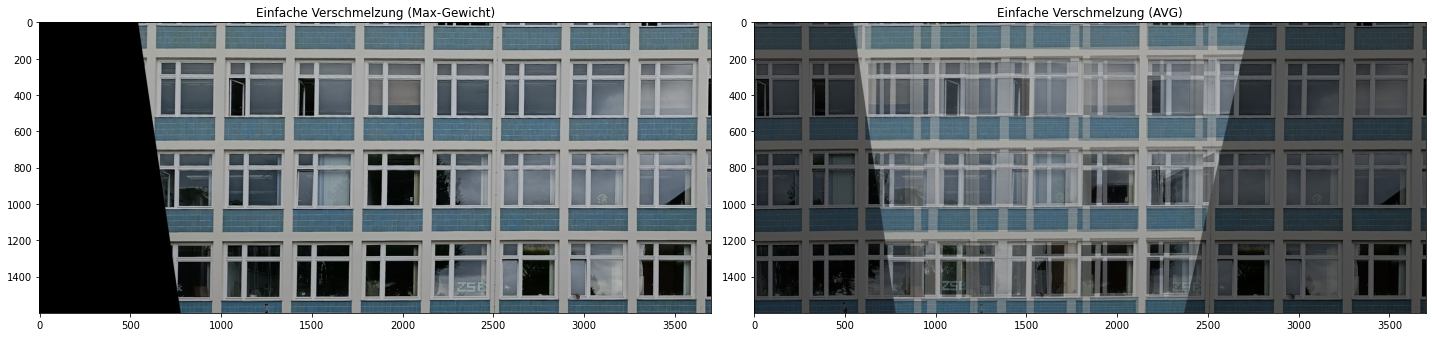

In [6]:
perform_task()


--- Bild 1 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=564, y=2157
p1: x=666, y=1455
p2: x=1632, y=1509
p3: x=1650, y=2181


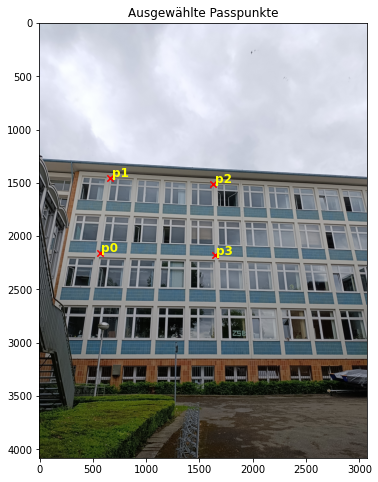

Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):

--- Bild 2 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=594, y=1941
p1: x=669, y=1236
p2: x=1659, y=1275
p3: x=1683, y=1968


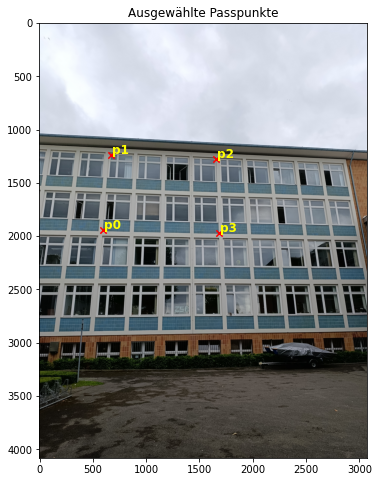

Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):

--- Bild 3 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=1206, y=1902
p1: x=1227, y=1173
p2: x=2220, y=1194
p3: x=2280, y=1908


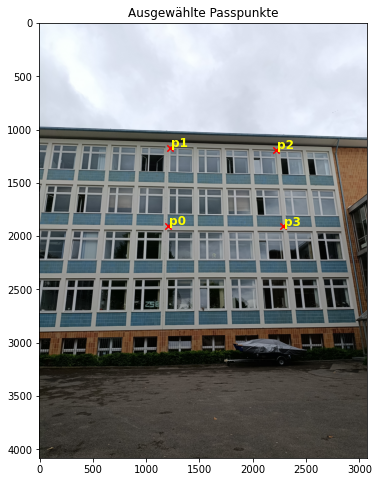

Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):

Erstelle Panorama mit einfacher Verschmelzung...


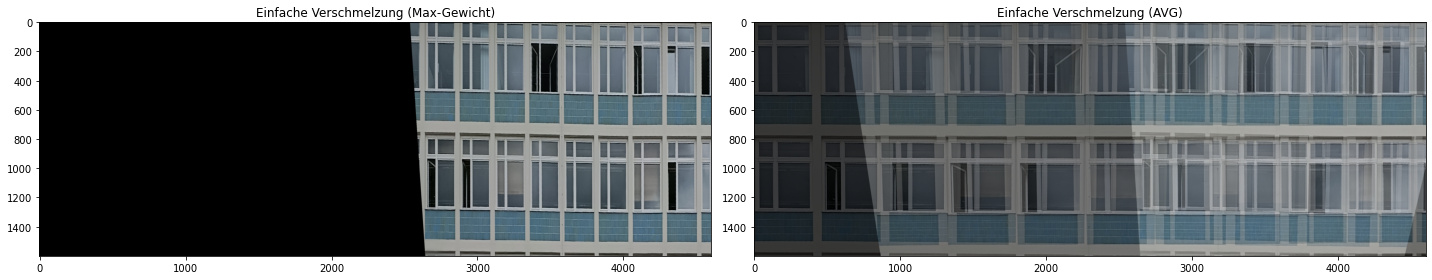

In [9]:
# 0 3000
# 0 1500
# 1800 1500
# 1800 3000


perform_task(3)

In [11]:

def perform_task1(n = 2):
    num_images = n
    images = []
    control_points_list = []
    destination_points_list = []

    # Lade Bilder und wähle Passpunkte
    for i in range(1, num_images + 1):
        filename = f"b{i}.jpg"
        if not os.path.exists(filename):
            print(f"Fehler: Datei {filename} nicht gefunden!")
            return

        # Bild laden und in RGB konvertieren
        img_bgr = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)

        print(f"\n--- Bild {i} ---")
        print(f"Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.")

        # Passpunkte auswählen
        points = select_points(filename, 4)
        if len(points) < 4:
            print("Fehler: Mindestens 4 Punkte benötigt!")
            return

        control_points_list.append(points.tolist())

        # Weltkoordinaten eingeben
        world_points = get_world_coordinates(points)
        destination_points_list.append(world_points)

    # Ausgabegröße berechnen (basierend auf Weltkoordinaten)
    all_world_points = np.vstack(destination_points_list)
    min_x, min_y = np.min(all_world_points, axis=0)
    max_x, max_y = np.max(all_world_points, axis=0)

    # Normalisierte Weltkoordinaten erstellen
    normalized_destination_list = []
    for dps in destination_points_list:
        normalized = [[x - min_x, y - min_y] for x, y in dps]
        normalized_destination_list.append(normalized)

    output_shape = (int(max_y - min_y) + 100, int(max_x - min_x) + 100)

    # Panoramen erstellen
    print("\nErstelle Panorama mit einfacher Verschmelzung...")
    panorama_simple_max = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blend_method='max',
        blending_type='simple'
    )
    print("Erstelle Panorama mit Multi-Band Blending...")
    panorama_multiband = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blending_type='multiband'
    )

    # Ergebnisse speichern
    cv2.imwrite('panorama_simple_1.jpg', cv2.cvtColor(panorama_simple_max, cv2.COLOR_RGB2BGR))
    cv2.imwrite('panorama_multiband_1.jpg', cv2.cvtColor(panorama_multiband, cv2.COLOR_RGB2BGR))

    # Ergebnisse anzeigen
    plt.figure(figsize=(20, 10))
    plt.subplot(121), plt.imshow(panorama_simple_max), plt.title('Einfache Verschmelzung (Max-Gewicht)')
    plt.subplot(122), plt.imshow(panorama_multiband), plt.title('Multi-Band Blending')
    plt.tight_layout()
    plt.savefig('panorama_comparison.jpg')
    plt.show()



--- Bild 1 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=576, y=2166
p1: x=663, y=1449
p2: x=1638, y=2184
p3: x=1629, y=1500


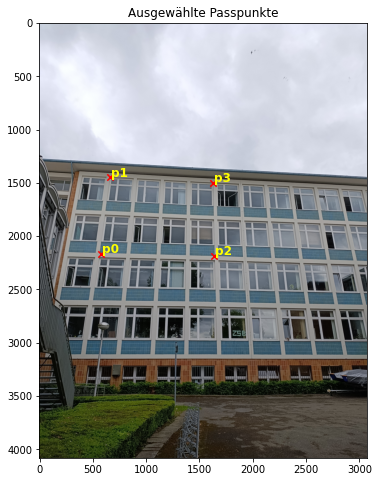

Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):

--- Bild 2 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=600, y=1944
p1: x=666, y=1230
p2: x=1662, y=1272
p3: x=1683, y=1968


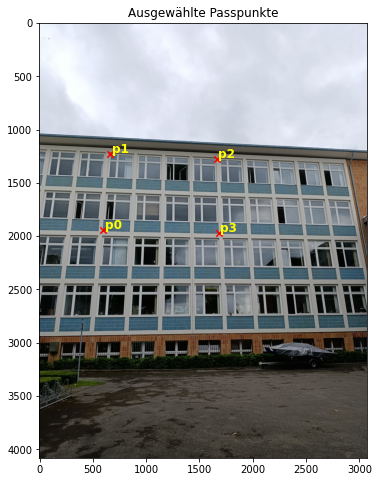

Geben Sie für jeden Punkt Weltkoordinaten ein (Format: x y):

Erstelle Panorama mit einfacher Verschmelzung...
Erstelle Panorama mit Multi-Band Blending...


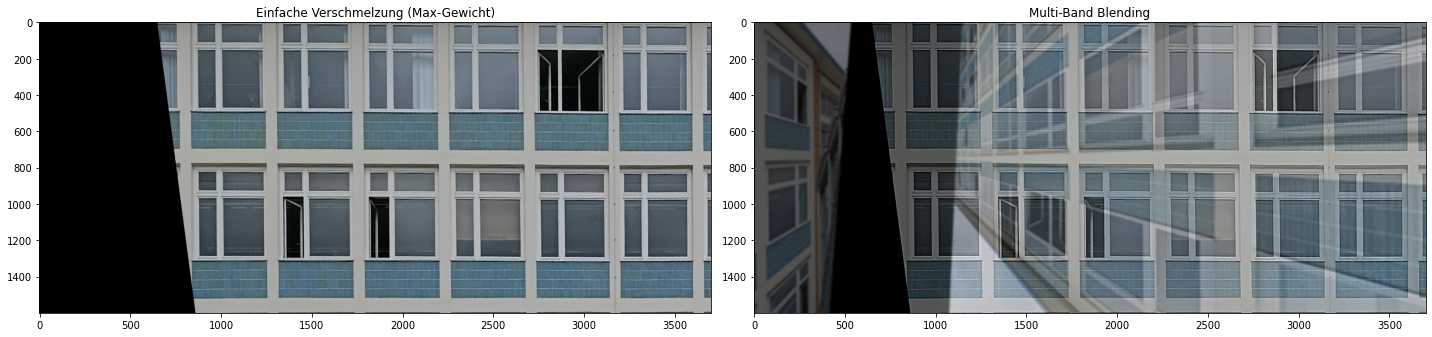

In [12]:
perform_task1()

In [13]:

# -------------------------------
# A: Projektive Entzerrung
# -------------------------------

def calculate_projective_transformation(control_points, destination_points):
    if len(control_points) != len(destination_points) or len(control_points) < 4:
        raise ValueError("Mindestens 4 Passpunkte mit Zielkoordinaten erforderlich.")

    n = len(control_points)
    A = np.zeros((2 * n, 9))

    for i in range(n):
        x, y = control_points[i]
        u, v = destination_points[i]
        A[2 * i] = [x, y, 1, 0, 0, 0, -u * x, -u * y, -u]
        A[2 * i + 1] = [0, 0, 0, x, y, 1, -v * x, -v * y, -v]

    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H / H[2, 2]

def projective_transform(image, H, output_shape):
    return cv2.warpPerspective(image, H, (output_shape[1], output_shape[0]))

# -------------------------------
# B: Auswahl von Passpunkten
# -------------------------------

def select_points(image_path, num_points=4, scale=0.33):
    image = cv2.imread(image_path)
    display = cv2.resize(image.copy(), None, fx=scale, fy=scale)
    selected = []

    def mouse(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            sx, sy = int(x / scale), int(y / scale)
            selected.append([sx, sy])
            cv2.circle(display, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("Select Points", display)

    cv2.imshow("Select Points", display)
    cv2.setMouseCallback("Select Points", mouse)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return selected

def get_world_coordinates(points):
    coords = []
    for i, (x, y) in enumerate(points):
        while True:
            try:
                inp = input(f"Weltkoordinaten für Punkt {i} (Bild: {x}, {y}): ")
                X, Y = map(float, inp.strip().split())
                coords.append([X, Y])
                break
            except:
                print("Ungültige Eingabe! Format: x y")
    return coords

# -------------------------------
# C: Verschmelzungsmethoden
# -------------------------------

def compute_weight_map(h, w):
    Y, X = np.indices((h, w))
    wx = 1 - 2 * np.abs(X - w / 2) / w
    wy = 1 - 2 * np.abs(Y - h / 2) / h
    return wx * wy

def blend_images(img1, img2, w1, w2, method="avg"):
    assert img1.shape == img2.shape, "Bilder müssen gleiche Form haben."
    output = np.zeros_like(img1, dtype=np.float32)

    if method == "max":
        mask = (w1 > w2)[..., None]
        output = np.where(mask, img1, img2)
    elif method == "avg":
        total = w1 + w2 + 1e-10
        for c in range(3):
            output[..., c] = (img1[..., c] * w1 + img2[..., c] * w2) / total
    return np.clip(output, 0, 255).astype(np.uint8)

# -------------------------------
# D: Multi-Band Blending
# -------------------------------

def multi_band_blend(img1, img2, w1, w2, sigma=5):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    low1 = cv2.GaussianBlur(img1, (0, 0), sigma)
    low2 = cv2.GaussianBlur(img2, (0, 0), sigma)

    high1 = img1 - low1
    high2 = img2 - low2

    total = w1 + w2 + 1e-10
    blended_low = (low1 * w1[..., None] + low2 * w2[..., None]) / total[..., None]
    mask = (w1 > w2)[..., None]
    blended_high = np.where(mask, high1, high2)

    result = blended_low + blended_high
    return np.clip(result, 0, 255).astype(np.uint8)

# -------------------------------
# Panorama-Erstellung
# -------------------------------

def create_panorama(images, cps_list, dps_list, out_shape, blend_method="avg", blending_type="simple"):
    warped_imgs = []
    weight_maps = []

    for img, cps, dps in zip(images, cps_list, dps_list):
        H = calculate_projective_transformation(cps, dps)
        warped = projective_transform(img, H, out_shape)
        warped_imgs.append(warped)
        h, w = warped.shape[:2]
        weight_maps.append(compute_weight_map(h, w))

    panorama = warped_imgs[0]
    total_weight = weight_maps[0]

    for i in range(1, len(warped_imgs)):
        if blending_type == "simple":
            panorama = blend_images(panorama, warped_imgs[i], total_weight, weight_maps[i], blend_method)
        elif blending_type == "multiband":
            panorama = multi_band_blend(panorama, warped_imgs[i], total_weight, weight_maps[i])

        if blend_method == "max":
            total_weight = np.maximum(total_weight, weight_maps[i])
        else:
            total_weight = total_weight + weight_maps[i]

    return panorama




In [14]:

def perform_task2(n=2):
    num_images = n
    images = []
    control_points_list = []
    destination_points_list = []

    for i in range(1, num_images + 1):
        filename = f"b{i}.jpg"
        if not os.path.exists(filename):
            print(f"Fehler: Datei {filename} nicht gefunden!")
            return

        img_bgr = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)

        print(f"\n--- Bild {i} ---")
        print("Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.")
        points = select_points(filename, 4)

        if len(points) < 4:
            print("Fehler: Mindestens 4 Punkte benötigt!")
            return

        control_points_list.append(points)
        world_points = get_world_coordinates(points)
        destination_points_list.append(world_points)

    all_world_points = np.vstack(destination_points_list)
    min_x, min_y = np.min(all_world_points, axis=0)
    max_x, max_y = np.max(all_world_points, axis=0)

    normalized_destination_list = []
    for dps in destination_points_list:
        normalized = [[x - min_x, y - min_y] for x, y in dps]
        normalized_destination_list.append(normalized)

    output_shape = (int(max_y - min_y) + 100, int(max_x - min_x) + 100)

    print("\nErstelle Panorama mit einfacher Verschmelzung...")
    panorama_simple_max = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blend_method='max',
        blending_type='simple'
    )

    print("Erstelle Panorama mit Multi-Band Blending...")
    panorama_multiband = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blending_type='multiband'
    )

    cv2.imwrite('panorama_simple_1.jpg', cv2.cvtColor(panorama_simple_max, cv2.COLOR_RGB2BGR))
    cv2.imwrite('panorama_multiband_1.jpg', cv2.cvtColor(panorama_multiband, cv2.COLOR_RGB2BGR))

    plt.figure(figsize=(20, 10))
    plt.subplot(121), plt.imshow(panorama_simple_max), plt.title('Einfache Verschmelzung (Max-Gewicht)')
    plt.subplot(122), plt.imshow(panorama_multiband), plt.title('Multi-Band Blending')
    plt.tight_layout()
    plt.savefig('panorama_comparison.jpg')
    plt.show()


--- Bild 1 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.

--- Bild 2 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.

Erstelle Panorama mit einfacher Verschmelzung...
Erstelle Panorama mit Multi-Band Blending...


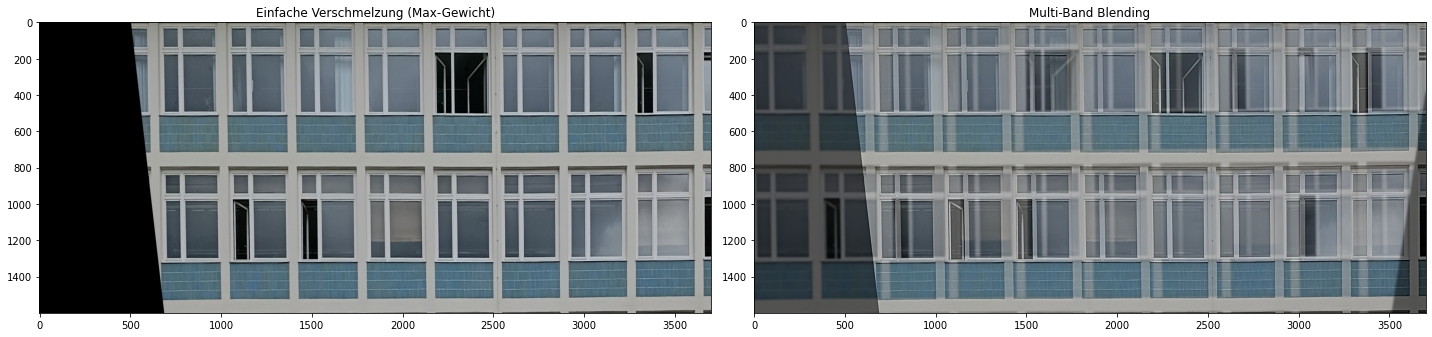

In [16]:
perform_task2()


--- Bild 1 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.

--- Bild 2 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.

--- Bild 3 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.

Erstelle Panorama mit einfacher Verschmelzung...
Erstelle Panorama mit Multi-Band Blending...


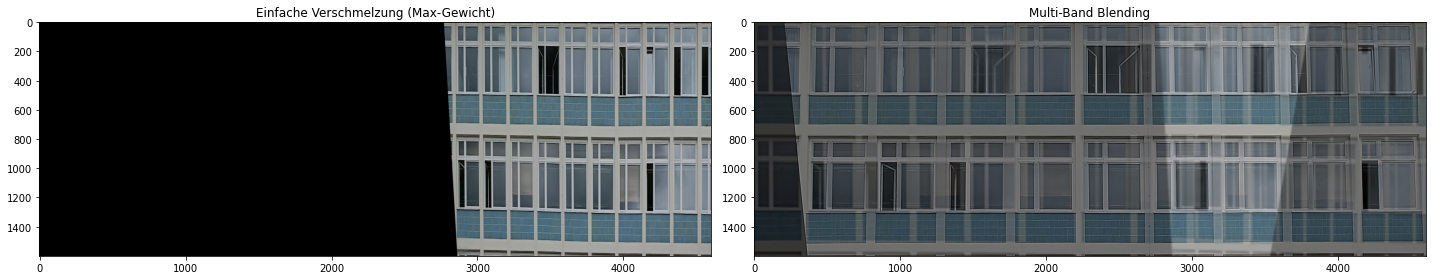

In [17]:
perform_task2(3)